# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots


from ISLP import load_data

import sklearn.model_selection as skm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from ISLP.models import \
     (ModelSpec as MS,
      Stepwise,
      sklearn_selected)

from statsmodels.api import OLS

from sklearn.neighbors import RadiusNeighborsRegressor
import sklearn.linear_model as skl

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

/usr/local/anaconda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/usr/local/anaconda/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Q1

In [2]:
# Load data
knn_data = pd.read_csv('KNN.csv')
X_knn, Y_knn = knn_data.loc[:, 'X'].values.reshape(-1,1), knn_data.loc[:, ' Y']

In [3]:
# Pre-processing to scale X values
scaler = StandardScaler(with_mean=True, with_std=True)

# 5-fold CV with shuffle
kfold = skm.KFold(n_splits=10,
           random_state=0,
           shuffle=True)

# Pipeline entails scaling then fitting nearest neighbors averaging
knn_avg = RadiusNeighborsRegressor()
pipe = Pipeline([('scaler', scaler),
                 ('knn_avg', knn_avg)])

# Grid of tau values to check
tau_values = np.linspace(0.1, 10, num=100)
param_grid = {'knn_avg__radius':tau_values}

# Grid search
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring="neg_mean_squared_error")
grid.fit(X_knn, Y_knn)

/usr/local/anaconda/lib/python3.9/site-packages/sklearn/neighbors/_regression.py:509: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/usr/local/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/anaconda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/anaconda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scori

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn_avg',
                                        RadiusNeighborsRegressor())]),
             param_grid={'knn_avg__radius': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ])},
             scoring='neg_mean_squared_error')

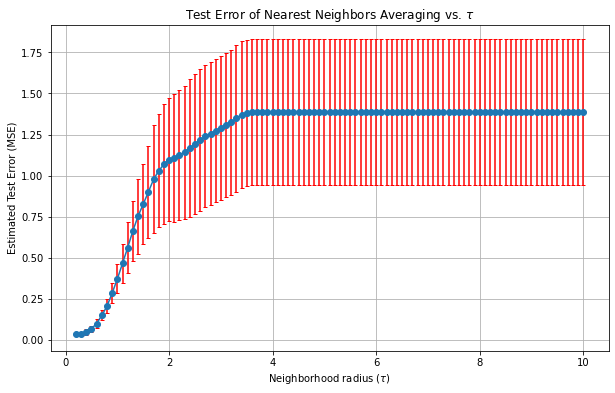

In [4]:
# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(tau_values, 
             -grid.cv_results_['mean_test_score'], 
             yerr=-grid.cv_results_['std_test_score'], 
             fmt='o-', ecolor='r', capsize=2)
plt.xlabel(r'Neighborhood radius ($\tau$)')
plt.ylabel('Estimated Test Error (MSE)')
plt.title(r'Test Error of Nearest Neighbors Averaging vs. $\tau$')
plt.grid(True)
plt.show()

# Q4

## (a)

In [5]:
college_data = load_data('college')
# One-hot encoding manually for categorical variable
college_data['Private'] = college_data['Private'].apply(lambda x: 1 if x == 'Yes' else 0)

design = MS(college_data.columns.drop('Apps')).fit(college_data)

X_college, y_college = design.transform(college_data), college_data['Apps']
X_train, X_test, y_train, y_test = skm.train_test_split(X_college,
                                                        y_college,
                                                        test_size=0.30,
                                                        random_state=42)

## (b)

In [6]:
# Function for getting training and test error from fitted model
def fitted_eval(model, X_train, y_train, X_test, y_test):

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    return {'rmse_train': rmse_train, 'rmse_test': rmse_test, 
            'mae_train': mae_train, 'mae_test': mae_test, 
            'r2_train': r2_train, 'r2_test': r2_test}

In [7]:
# Fit linear model using least squares and get test/train error
linreg = OLS(y_train, X_train).fit()
linreg_res = fitted_eval(linreg, X_train, y_train, X_test, y_test)
linreg_res

{'rmse_train': 897.887835923859,
 'rmse_test': 1389.8932312257878,
 'mae_train': 508.05307287394805,
 'mae_test': 744.877452519234,
 'r2_train': 0.9482108809188478,
 'r2_test': 0.8573055984601535}

## (c)

In [8]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [9]:
forward_mse = sklearn_selected(OLS,
                               strategy)
forward_mse.fit(X_train, y_train)

forward_mse_res = fitted_eval(forward_mse, X_train, y_train, X_test, y_test)
forward_mse_res

{'rmse_train': 897.8878359238589,
 'rmse_test': 1389.893231225706,
 'mae_train': 508.0530728740234,
 'mae_test': 744.8774525191867,
 'r2_train': 0.9482108809188478,
 'r2_test': 0.8573055984601704}

In [10]:
forward_mse.selected_state_

('Accept',
 'Books',
 'Enroll',
 'Expend',
 'F.Undergrad',
 'Grad.Rate',
 'Outstate',
 'P.Undergrad',
 'Personal',
 'PhD',
 'Private',
 'Room.Board',
 'S.F.Ratio',
 'Terminal',
 'Top10perc',
 'Top25perc',
 'perc.alumni')

In [24]:
X_train.columns

Index(['intercept', 'Private', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
       'Grad.Rate'],
      dtype='object')

In [11]:
# Scoring function for (negative) AIC for linear regression
def negAIC(estimator, X, Y):
    "Negative AIC"
    n, p = X.shape
    Yhat = estimator.predict(X)
    MSE = np.mean((Y - Yhat)**2)
    return n + n * np.log(MSE) + 2 * (p + 1)

In [12]:
forward_aic = sklearn_selected(OLS,
                               strategy,
                               scoring=negAIC)
forward_aic.fit(X_train, y_train)

forward_aic_res = fitted_eval(forward_aic, X_train, y_train, X_test, y_test)
forward_aic_res

{'rmse_train': 3942.263290826188,
 'rmse_test': 3673.1163770741723,
 'mae_train': 2518.501142157583,
 'mae_test': 2569.0256584258063,
 'r2_train': 0.0016436149605201233,
 'r2_test': 0.003417098659288076}

In [13]:
forward_aic.selected_state_

('Outstate',)

In [14]:
# Scoring function for (negative) BIC for linear regression
def negBIC(estimator, X, Y):
    "Negative AIC"
    n, p = X.shape
    Yhat = estimator.predict(X)
    MSE = np.mean((Y - Yhat)**2)
    return - (p + 1) * np.log(n) - n * np.log(MSE / n)

In [25]:
forward_bic = sklearn_selected(OLS,
                               strategy,
                               scoring=negBIC)
forward_bic.fit(X_train, y_train)

forward_bic_res = fitted_eval(forward_bic, X_train, y_train, X_test, y_test)
forward_bic_res

{'rmse_train': 908.342428316711,
 'rmse_test': 1406.8152034323937,
 'mae_train': 513.3017855832746,
 'mae_test': 744.8054270765265,
 'r2_train': 0.9469978424670409,
 'r2_test': 0.8538098335058457}

In [16]:
forward_bic.selected_state_

('Accept',
 'Enroll',
 'Expend',
 'Outstate',
 'PhD',
 'Private',
 'Room.Board',
 'Top10perc')

## (d)

In [17]:
lambdas = 10**np.linspace(8, -2, 100) / y_train.std()

ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0,
                           cv=kfold)
piperidgeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
piperidgeCV.fit(X_train, y_train)

fitted_eval(piperidgeCV, X_train, y_train, X_test, y_test)

/usr/local/anaconda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/anaconda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4005773879.8295517, tolerance: 801260.9808276638
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/anaconda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/anaconda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: C

{'rmse_train': 897.8878368249141,
 'rmse_test': 1389.8766215297796,
 'mae_train': 508.05019333957256,
 'mae_test': 744.8696425993186,
 'r2_train': 0.9482108808149041,
 'r2_test': 0.857309008932867}

In [18]:
X_train.columns[piperidgeCV.named_steps['ridge'].coef_ != 0]


Index(['Private', 'Accept', 'Enroll', 'Top10perc', 'Top25perc', 'F.Undergrad',
       'P.Undergrad', 'Outstate', 'Room.Board', 'Books', 'Personal', 'PhD',
       'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate'],
      dtype='object')

## (e)

In [19]:
lassoCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=1,
                           cv=kfold)
pipelassoCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipelassoCV.fit(X_train, y_train)

fitted_eval(pipelassoCV, X_train, y_train, X_test, y_test)

{'rmse_train': 897.8878359238597,
 'rmse_test': 1389.893229800611,
 'mae_train': 508.05306984123973,
 'mae_test': 744.8774496512257,
 'r2_train': 0.9482108809188476,
 'r2_test': 0.8573055987527872}

In [20]:
X_train.columns[pipelassoCV.named_steps['lasso'].coef_ != 0]

Index(['Private', 'Accept', 'Enroll', 'Top10perc', 'Top25perc', 'F.Undergrad',
       'P.Undergrad', 'Outstate', 'Room.Board', 'Books', 'Personal', 'PhD',
       'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate'],
      dtype='object')